AVLTree({0.0: 0, 3.0: -1})


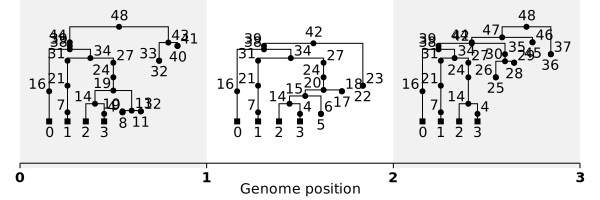

In [398]:
import hgt_sim_args
import msprime
import hgt_simulation
import numpy as np
import random
from collections import namedtuple
from collections import defaultdict
from collections import deque

num_samples = 4
sim_num_sites = 3
hgt_rate = 0.5

core_tree = msprime.sim_ancestry(
        samples=num_samples,
        sequence_length=1,
        ploidy=1,
        recombination_rate=0,
        gene_conversion_rate=0,
        gene_conversion_tract_length=1,  # One gene
    )

ce_from_nwk = core_tree.first().newick()

args = hgt_sim_args.Args(
    sample_size=num_samples,
    num_sites=sim_num_sites,
    gene_conversion_rate=0,
    recombination_rate=0,
    hgt_rate=hgt_rate,
    ce_from_ts=None,
    ce_from_nwk=ce_from_nwk,
    random_seed=1
)

ts, hgt_edges = hgt_simulation.run_simulate(args)

ts.draw_svg()

In [402]:
### Place mutations

alleles = ["absent", "present"]

# Place one mutation per site, e.g. genome position

gains_model = msprime.MatrixMutationModel(
    alleles = alleles,
    root_distribution=[1, 0],
    transition_matrix=[
        [0, 1],
        [0, 1],
    ],
)

ts_gains = msprime.sim_mutations(ts, rate=1, model = gains_model, keep = True)

while (ts_gains.num_sites < ts_gains.sequence_length):
    ts_gains = msprime.sim_mutations(ts_gains, rate=1, model = gains_model, keep = True)

# Remove superfluous mutations

tables = ts_gains.dump_tables()

mutations_by_site = {}
for mut in tables.mutations:
    if mut.site not in mutations_by_site:
        mutations_by_site[mut.site] = []
    mutations_by_site[mut.site].append(mut)

# Erstelle eine neue Mutations-Tabelle mit nur einer zufälligen Mutation pro Site
tables.mutations.clear()
for site, mutations in mutations_by_site.items():
    selected_mutation = random.choice(mutations)  # Wähle eine zufällige Mutation
    tables.mutations.add_row(
        site=selected_mutation.site,
        node=selected_mutation.node,
        derived_state=selected_mutation.derived_state,
        parent=-1,
        metadata=None,
        time=selected_mutation.time,
    )

    # Add sentinel mutations at the leafs:

    for leaf_position in range(num_samples):
        tables.mutations.add_row(
            site = selected_mutation.site,
            node = leaf_position,
            derived_state = "absent",
            time = 0.00000000001,
        )

print(tables.mutations)

ts_gains = tables.tree_sequence()

print(ts_gains.tables.mutations)

"""
Mutation = namedtuple("Mutation", ["node", "time"])

present_mutations = {}

site = 0
for tree in ts.trees():
    
    nodes = [n for n in tree.nodes()]
    probabilities = np.array([tree.branch_length(n) for n in nodes]) / tree.total_branch_length
    
    for i in range(int(tree.span)):

        mutation_node = np.random.choice(nodes, size=1, p=probabilities)[0]

        mutation_time = random.uniform(tree.time(mutation_node), tree.time(tree.parent(mutation_node)))
        
        tables.mutations.add_row(
            site = site,
            node = mutation_node,
            derived_state = "present",
            #parent=parent_id,
            #metadata=mutation.metadata,
            time=mutation_time,
        )
        
        tables.sites.add_row(position=site, ancestral_state="absent")

        present_mutations[site] = Mutation(node=mutation_node, time=mutation_time)

        # Add sentinel mutations at the leafs:

        for leaf_position in range(num_samples):
            tables.mutations.add_row(
                site = site,
                node = leaf_position,
                derived_state = "absent",
                time = 0.00000000001,
            )
    
        site += 1
"""
#ts_gains = tables.tree_sequence()

# Place losses:
rho = 0.3

losses_model = msprime.MatrixMutationModel(
    alleles = alleles,
    root_distribution=[1, 0],
    transition_matrix=[
        [1, 0],
        [1, 0],
    ],
)

ts_gains_losses = msprime.sim_mutations(ts_gains, rate=rho, model = losses_model, keep = True)

"""
# Consistency check:
print("Expected number of mutations:", [1 + tree.span*tree.total_branch_length*rho for tree in ts_gains_losses.trees()])

print(ts_gains_losses.tables.mutations)
print(present_mutations)
ts_gains_losses.draw_svg()
"""
print(ts_gains_losses.tables.mutations)

╔══╤════╤════╤══════════╤═════════════╤══════╤════════╗
║id│site│node│time      │derived_state│parent│metadata║
╠══╪════╪════╪══════════╪═════════════╪══════╪════════╣
║0 │   0│  44│2.14905536│      present│    -1│        ║
║1 │   0│   0│0.00000000│       absent│    -1│        ║
║2 │   0│   1│0.00000000│       absent│    -1│        ║
║3 │   0│   2│0.00000000│       absent│    -1│        ║
║4 │   0│   3│0.00000000│       absent│    -1│        ║
║5 │   1│   2│0.30758318│      present│    -1│        ║
║6 │   1│   0│0.00000000│       absent│    -1│        ║
║7 │   1│   1│0.00000000│       absent│    -1│        ║
║8 │   1│   2│0.00000000│       absent│    -1│        ║
║9 │   1│   3│0.00000000│       absent│    -1│        ║
║10│   2│  26│1.49767719│      present│    -1│        ║
║11│   2│   0│0.00000000│       absent│    -1│        ║
║12│   2│   1│0.00000000│       absent│    -1│        ║
║13│   2│   2│0.00000000│       absent│    -1│        ║
║14│   2│   3│0.00000000│       absent│    -1│  

0
deque([(44, False, False)])
deque([(39, False, False)])
deque([(38, False, False)])
deque([(16, False, False), (34, False, False)])
deque([(34, False, False), (0, False, False)])
deque([(0, False, False), (27, False, False), (31, False, False)])
deque([(27, False, False), (31, False, False)])
deque([(31, False, False), (24, False, False)])
deque([(24, False, False), (21, False, False)])
deque([(21, False, False), (19, False, False)])
deque([(19, False, False)])
deque([(13, False, False), (14, False, False)])
deque([(14, False, False), (10, False, False), (12, False, False)])
deque([(10, False, False), (12, False, False), (2, False, False), (4, False, False)])
deque([(12, False, False), (2, False, False), (4, False, False), (9, False, False)])
deque([(2, False, False), (4, False, False), (9, False, False), (11, False, False)])
deque([(4, False, False), (9, False, False), (11, False, False)])
deque([(9, False, False), (11, False, False), (3, False, False)])
deque([(11, False, False), (

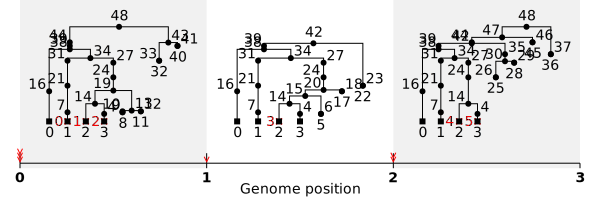

In [417]:
### Calculate the gene absence presence matrix:

MutationRecord = namedtuple('MutationRecord', ['site_id', 'mutation_id', 'node', 'is_hgt'])

tables = ts_gains_losses.dump_tables()
tables.mutations.clear()

hgt_parent_nodes = [edge.parent-1 for edge in hgt_edges]
hgt_parent_children = defaultdict(list)
    
for parent in hgt_parent_nodes:
    hgt_parent_children[parent].append(parent-1)
        
for tree in ts_gains_losses.trees():
    
    for site in tree.sites():
        print(site.id)
        mutations = site.mutations
        present_mutation = [m for m in mutations if m.derived_state == "present"][0]
        absent_mutations = [m for m in mutations if m.derived_state == "absent"]
        absent_mutation_nodes = {m.node for m in mutations if m.derived_state == "absent"}

        nodes_to_process = deque([(present_mutation.node, False, False)])
        # The second variable describes if a hgt edge has passed in the whole way down to the actual node. 
        # The third describes if a hgt edge was passed in the last step.

        child_mutations = []
        
        visited = set()  # Prevents duplicate processing of nodes.

        if present_mutation.node < num_samples: # Gain directly above leaf:
            if present_mutation.id == sorted([mut for mut in mutations if mut.node == present_mutation.node], key=lambda m: m.time)[1].id:
                sentinel_mutation = min([mut for mut in absent_mutations if mut.node == present_mutation.node], key=lambda m: m.time)
                child_mutations.append(MutationRecord(
                    site_id=site.id,
                    mutation_id=sentinel_mutation.id,
                    node=sentinel_mutation.node,
                    is_hgt=False
                ))


        else:
            while nodes_to_process:
                print(nodes_to_process)
                child_node = nodes_to_process.popleft()
                                        
                # Process the node only if it has not been visited yet.
                if child_node in visited:
                    continue
                visited.add(child_node)
    
                # If there is a mutation on the edge, find the earliest one.
                if not child_node[2] and child_node[0] in absent_mutation_nodes:
                    
                    absent_mutation_after_gain_at_node = [mut for mut in absent_mutations if mut.node == child_node[0] and mut.time < present_mutation.time]
                    
                    if absent_mutation_after_gain_at_node: # not empty
                        earliest_mutation = max(
                            [mut for mut in absent_mutations if mut.node == child_node[0] and mut.time < present_mutation.time], 
                            key=lambda m: m.time
                        )
        
                        if earliest_mutation.time == 0.00000000001:
                            earliest_mutation.derived_state = "present"
                            child_mutations.append(MutationRecord(
                                site_id=site.id,
                                mutation_id=earliest_mutation.id,
                                node=earliest_mutation.node,
                                is_hgt=child_node[1]
                            ))
                    else:
                        for child in tree.children(child_node[0]):
                            nodes_to_process.extend([(child, child_node[1], False)])
                        if hgt_parent_children[child_node[0]]:
                            nodes_to_process.extend([(hgt_parent_children[child_node[0]][0], True, True)])  
                        
        
                # If there is no mutation, add child nodes.
                else:
                    for child in tree.children(child_node[0]):
                        nodes_to_process.extend([(child, child_node[1], False)])
                    if hgt_parent_children[child_node[0]]:
                        nodes_to_process.extend([(hgt_parent_children[child_node[0]][0], True, True)])

        child_mutations.sort(key=lambda mut: not mut.is_hgt) # Will set is_hgt to False later if there are paths without hgt events to the leaf.
        print("Child mutations: ", child_mutations)

        # We have to adress multiple paths to the same destiny, some with hgt and other without it:
        unique_mutations = {}

        for mut in child_mutations:
            if mut.node not in unique_mutations:
                unique_mutations[mut.node] = mut
            else:
                existing_mut = unique_mutations[mut.node]
                if not existing_mut.is_hgt or not mut.is_hgt:
                    unique_mutations[mut.node] = mut._replace(is_hgt=False)
        
        child_mutations_filtered = list(unique_mutations.values())
        print(child_mutations_filtered)

        for mutation in child_mutations_filtered:

            #tables.mutations[mutation.mutation_id] = tables.mutations[mutation.mutation_id].replace(derived_state = "present", metadata = bytes([mutation.is_hgt]))

            tables.mutations.add_row(
                site=site.id,
                node=mutation.node,
                derived_state="present",
                parent=-1,
                metadata=bytes([mutation.is_hgt]),
                time=0.00000000001,
            )
    
mts = tables.tree_sequence()

gene_absence_presence_matrix = []

for var in mts.variants():
    gene_absence_presence_matrix.append(var.genotypes)

print(np.array(gene_absence_presence_matrix))

print(mts.tables.mutations)

mts.draw_svg()

In [410]:
child_mutations.append(MutationRecord(site_id=2, mutation_id=22, node=2, is_hgt=False))
child_mutations

[MutationRecord(site_id=2, mutation_id=22, node=2, is_hgt=True),
 MutationRecord(site_id=2, mutation_id=23, node=3, is_hgt=True),
 MutationRecord(site_id=2, mutation_id=22, node=2, is_hgt=False)]

In [411]:
unique_mutations = {}

for mut in child_mutations:
    if mut.node not in unique_mutations:
        unique_mutations[mut.node] = mut
    else:
        existing_mut = unique_mutations[mut.node]
        if not existing_mut.is_hgt or not mut.is_hgt:
            unique_mutations[mut.node] = mut._replace(is_hgt=False)

child_mutations_filtered = list(unique_mutations.values())
print("child_mutations_filtered ", child_mutations_filtered)

child_mutations_filtered  [MutationRecord(site_id=2, mutation_id=22, node=2, is_hgt=False), MutationRecord(site_id=2, mutation_id=23, node=3, is_hgt=True)]
